In [4]:
import h5py as h5
import numpy as np
import os
import matplotlib.pyplot as plt

# we will use astropy for some useful constants and units 
from astropy import units as u
from astropy import constants as const

In [5]:
from scipy.stats.kde import gaussian_kde
from numpy import linspace

In [6]:
def load_data(ns_kicks, sigmas):    
    SN_KICK_BH_ALL = []
    SN_KICK_NS_ALL = []
    NS_KICK_MULT = []
    SIGMAS = []
       
    
    for ns_kick in ns_kicks:
        for sigma in sigmas:
            path = os.environ['WORK'] + f'/supernova_remnant_bse/bh_{bh_kick}_ns_{ns_kick}_sigma_{sigma}_combined.h5'
            print("loading data from", path)
            
            fdata = h5.File(path, 'r')
            
            SN_STELLAR_TYPE = fdata['BSE_Supernovae']["Stellar_Type(SN)"][...].squeeze()
            SN_TYPE = fdata['BSE_Supernovae']["SN_Type(SN)"][...].squeeze() 
            SN_KICK = fdata['BSE_Supernovae']["Applied_Kick_Magnitude(SN)"][...].squeeze()

            maskSN_NS = ((SN_STELLAR_TYPE ==13) * (SN_TYPE == 1)) # select NSs, ignore electron capture SN
            maskSN_BH = ((SN_STELLAR_TYPE ==14) * (SN_TYPE == 1)) # select BHs, ignore electron capture SN
            
            SN_KICK_NS = SN_KICK[maskSN_NS]
            SN_KICK_BH = SN_KICK[maskSN_BH] 

            fdata.close()
            
            SN_KICK_NS_ALL.append(SN_KICK_NS)
            SN_KICK_BH_ALL.append(SN_KICK_BH)
            NS_KICK_MULT.append(ns_kick)
            SIGMAS.append(sigma)
            
    return SN_KICK_NS_ALL, SN_KICK_BH_ALL, NS_KICK_MULT, SIGMAS


In [7]:
# this is just a little function that we will use to make the plot more beautiful (bigger ticks, labels)
# However, you do not have to use this (just uncommoment "layoutAxes" everywhere)
from matplotlib.ticker import (FormatStrFormatter,
                               AutoMinorLocator)

def layoutAxes(ax, nameX='', nameY='', \
               labelSizeMajor = 10, fontsize = 18, second=False, labelpad=None, setMinor=True):
    """
    Tiny code to do the layout for axes in matplotlib
    """
    tickLengthMajor = 10
    tickLengthMinor = 5
    tickWidthMajor  = 1.5
    tickWidthMinor  = 1.5
    
    #rc('axes', linewidth=2)
    #label1 always refers to first axis not the twin 
    if not second:
        for tick in ax.xaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
    if second:
        for tick in ax.xaxis.get_major_ticks():
            tick.label2.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
        for tick in ax.yaxis.get_major_ticks():
            tick.label2.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.2)
    ax.tick_params(length=tickLengthMajor, width=tickWidthMajor, which='major')
    ax.tick_params(length=tickLengthMinor, width=tickWidthMinor, which='minor')
    ax.set_xlabel(nameX, fontsize=fontsize,labelpad=labelpad)#,fontweight='bold')
    ax.set_ylabel(nameY, fontsize=fontsize,labelpad=labelpad)#, fontweight='bold')    
    
    if setMinor==True:
        # add minor ticks:
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())

    return ax


# Load in the data files

In [8]:
bh_kick = 200
ns_kicks = [500]
sigmas = [0.1, 0.2, 0.3, 0.4, 0.5]

SN_KICK_NS_ALL, SN_KICK_BH_ALL, NS_KICK_MULT, SIGMAS = load_data(ns_kicks, sigmas)

loading data from /work2/08178/vkapil/frontera/supernova_remnant_bse/bh_200_ns_500_sigma_0.1_combined.h5
loading data from /work2/08178/vkapil/frontera/supernova_remnant_bse/bh_200_ns_500_sigma_0.2_combined.h5
loading data from /work2/08178/vkapil/frontera/supernova_remnant_bse/bh_200_ns_500_sigma_0.3_combined.h5
loading data from /work2/08178/vkapil/frontera/supernova_remnant_bse/bh_200_ns_500_sigma_0.4_combined.h5
loading data from /work2/08178/vkapil/frontera/supernova_remnant_bse/bh_200_ns_500_sigma_0.5_combined.h5


In [9]:
# Define a dictionary to map v_ns and sigma to their arrays
kick_models = {}
sig = len(sigmas)
vns = len(ns_kicks)

for i in range(len(ns_kicks)):
    kick_models[f"NS_{ns_kicks[i]}_RANGE"] = np.arange(i*sig, (i*sig)+sig, 1)

for i in range(len(sigmas)):
    kick_models[f"SIGMA_{sigmas[i]}_RANGE"] = np.arange(i, (vns*sig) + i, sig)

kick_models["ALL"] = np.arange(0, vns*sig, 1)

In [10]:
print(kick_models["NS_500_RANGE"])
# print(kick_models["NS_350_RANGE"])
# print(kick_models["NS_450_RANGE"])

[0 1 2 3 4]


In [11]:
print(kick_models["SIGMA_0.1_RANGE"])
print(kick_models["SIGMA_0.2_RANGE"])
print(kick_models["SIGMA_0.3_RANGE"])
print(kick_models["SIGMA_0.4_RANGE"])
print(kick_models["SIGMA_0.5_RANGE"])

print(kick_models["ALL"])

[0]
[1]
[2]
[3]
[4]
[0 1 2 3 4]


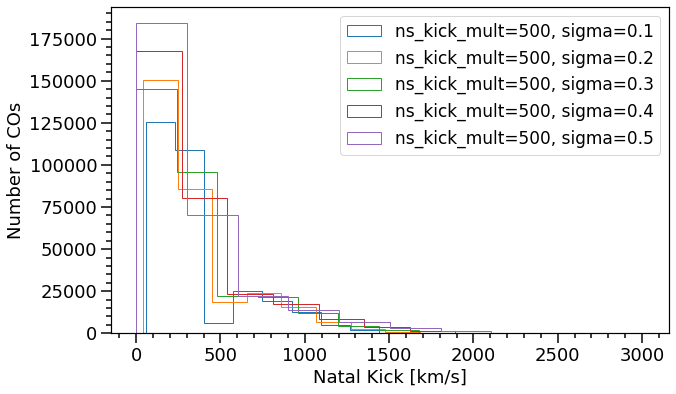

In [12]:
f, ax= plt.subplots(1, 1,  figsize=(10,6)) 

PLOT_RANGE = kick_models["NS_500_RANGE"]
# PLOT_RANGE = np.intersect1d(kick_models["NS_300_RANGE"], kick_models["SIGMA_0.3_RANGE"])
# PLOT_RANGE = kick_models["ALL"]

for i in PLOT_RANGE:
    plt.hist(SN_KICK_NS_ALL[i], label=f'ns_kick_mult={NS_KICK_MULT[i]}, sigma={SIGMAS[i]}', histtype='step');

layoutAxes(ax=ax, nameX='Natal Kick [km/s]',\
           nameY='Number of COs')
plt.legend(fontsize=17)
plt.show()

In [13]:
def plot_kde(PLOT_RANGE):
    f, ax= plt.subplots(1, 1,  figsize=(10,6)) 
    
    for i in PLOT_RANGE:
        kde_NS = gaussian_kde( SN_KICK_NS_ALL[i] )
        NS_dist_space = linspace( min(SN_KICK_NS_ALL[i]), max(SN_KICK_NS_ALL[i]), 100 )

        plt.plot( NS_dist_space, kde_NS(NS_dist_space), label=f'ns_kick_mult={NS_KICK_MULT[i]}, sigma={SIGMAS[i]}');

    layoutAxes(ax=ax, nameX='Natal Kick [km/s]',\
               nameY='Kick Velocity prob dist [km/s ^-1]')

    plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))

    # plt.ylim(0, 5e-3)
    plt.xlim(0, 1200)

    plt.legend(fontsize=17)
    plt.show()


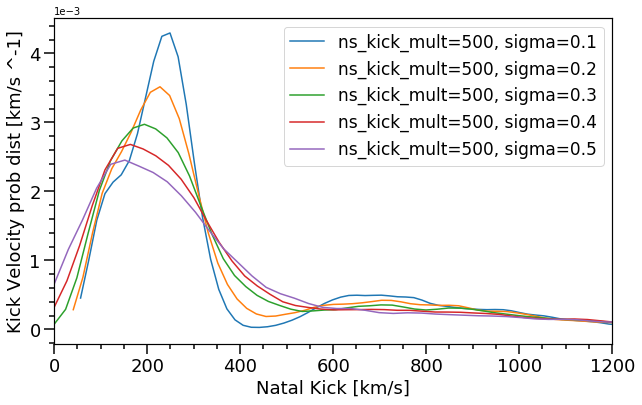

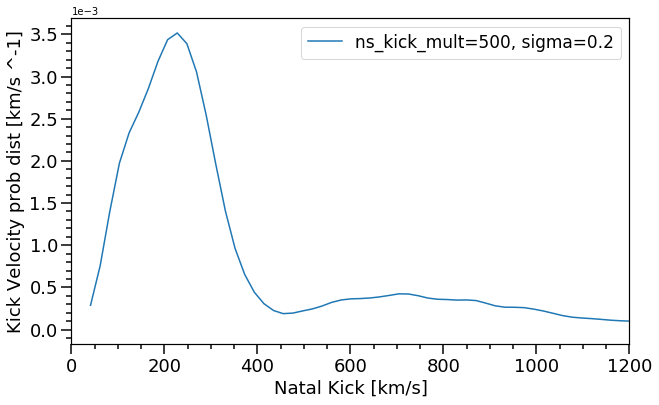

In [14]:
plot_kde(kick_models["NS_500_RANGE"])
plot_kde(kick_models["SIGMA_0.2_RANGE"])